In [1]:
import sys
sys.path.insert(0, '../src/')
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph
import scipy.sparse as sp
from scipy.spatial import distance_matrix
import networkx as nx


from net.utils import *
from net import utils_netgan as utils
import net.net as net

# 1) kNN from a Gaussian

In [2]:
def main(A, H, steps, optimizer_args):
    # Remove isolated and pendant nodes because of assertion error 
    A = A.toarray()
    degrees = A.sum(axis=-1)
    A = A[degrees>1]
    A = A[:, degrees>1]
    A = sp.csr_matrix(A)
    
    # Split into train, test, and validation
    val_share = 0.1
    test_share = 0.05
    seed = 481516234
    train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(A, val_share, test_share, seed, undirected=True, connected=True, asserts=True)
    train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
    assert (train_graph.toarray() == train_graph.toarray().T).all()
    
    # Apply pipeline to generate a graph with our method
    H = H
    W = train_graph.toarray()
    W /= W.sum()

    netmodel = net.NetWithoutSampling(W=W, 
                                      H=H, 
                                      loggers=[net.GraphStatisticsLoggerWithoutSampling(train_graph, 
                                                                                        val_ones,
                                                                                        val_zeros,
                                                                                        log_every=5),
                                               net.OverlapLoggerWithoutSampling(train_graph, print_every=50)])

    netmodel.train(steps=steps,
                   optimizer_fn=torch.optim.Adam,
                   optimizer_args=optimizer_args)

    transition_matrix = netmodel()

    scores_matrix = scores_matrix_from_transition_matrix(transition_matrix=transition_matrix,
                                                         symmetric=True)
    scores_matrix = sp.csr_matrix(scores_matrix)

    sampled_graph = utils.graph_from_scores(scores_matrix, train_graph.sum())
    statistics_logger = netmodel.loggers[0]
    return train_graph, sampled_graph, statistics_logger

In [3]:
def get_cov(princ_comp, eigvals):
    # Find vector orthogonal to princ_comp
    if princ_comp[0] != 0:
        w = np.array([-princ_comp[1] / princ_comp[0], 1])
    else:
        w = np.array([1, 0])
    princ_comp = princ_comp / np.linalg.norm(princ_comp)
    w = w / np.linalg.norm(w)
    S = np.array([princ_comp, w]).T
    cov = (S @ np.diag([eigvals[0], eigvals[1]])) @ S.T
    return cov
        
def get_gaussian(n_samples, mean, cov):
    Xs = np.random.multivariate_normal(mean=mean, cov=cov, size=n_samples)
    return Xs

def plot_graph(Xs, A, classes=None):
    Is, Js = A.nonzero()
    nonzero_indices = np.array((Is, Js)).T
    
    f, axs = plt.subplots(figsize=(12,12))

    for l in range(nonzero_indices.shape[0]):
        style = 'ko-'
        if classes is not None:
            if classes[nonzero_indices[l][0]] != classes[nonzero_indices[l][1]]:
                style = 'bo--'
        axs.plot(Xs[nonzero_indices[l], 0], Xs[nonzero_indices[l], 1], style)
    plt.show()

def plot_compare(Xs, train_graph, sampled_graph):
    f, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12,12))
    plt.tight_layout()
    
    graphs = [[train_graph, sampled_graph], [train_graph * sampled_graph, (1 - train_graph) * sampled_graph]]
    titles = [['True graph', 'Generated Graph'], ['Shared edges', 'New edges']]
    styles = [['ko-', 'ko-'], ['bo-', 'ro-']]
    for row in [0, 1]:
        for col in [0,1]:        
            A = graphs[row][col]
            A = np.tril(A)
            Is, Js = A.nonzero()
            nonzero_indices = np.array((Is, Js)).T
            for l in range(nonzero_indices.shape[0]):
                axs[row, col].plot(Xs[nonzero_indices[l], 0], Xs[nonzero_indices[l], 1], styles[row][col])
            axs[row, col].set_title(titles[row][col]) 
            
def get_average_edgelength(Xs, A):
    A = np.tril(A)
    Is, Js = A.nonzero()
    nonzero_indices = np.array((Is, Js)).T
    avg_edgelength = 0
    num_edges = nonzero_indices.shape[0]
    for l in range(num_edges):
        avg_edgelength += np.linalg.norm(Xs[nonzero_indices[l][0]] - Xs[nonzero_indices[l][1]])
    return avg_edgelength / num_edges            
            
def classes_to_points(sizes):
    K = len(sizes)
    Ys = np.zeros(np.array(sizes).sum())
    Xs = np.zeros((np.array(sizes).sum(), 2))
    thetas = [2*np.pi * k / K for k in range(1, K+1)]
    pointer=0
    for k in range(K):    
        class_points = np.random.multivariate_normal(mean=[np.cos(thetas[k]), np.sin(thetas[k])],
                                                 cov=0.05 * np.eye(2),
                                                 size=sizes[k])
        Xs[pointer:pointer+sizes[k], :] = class_points
        Ys[pointer:pointer+sizes[k]] = k
        pointer += sizes[k]
    return Xs, Ys       

def get_ratio(A, Ys):
    A = np.tril(A)
    Is, Js = A.nonzero()
    nonzero_indices = np.array((Is, Js)).T    
    num_edges = nonzero_indices.shape[0]
    between_edges = 0
    for l in range(num_edges):
        if Ys[nonzero_indices[l][0]] != Ys[nonzero_indices[l][1]]:
            between_edges += 1
    ratio = num_edges / between_edges - 1
    return ratio

#### Generate kNN graph 

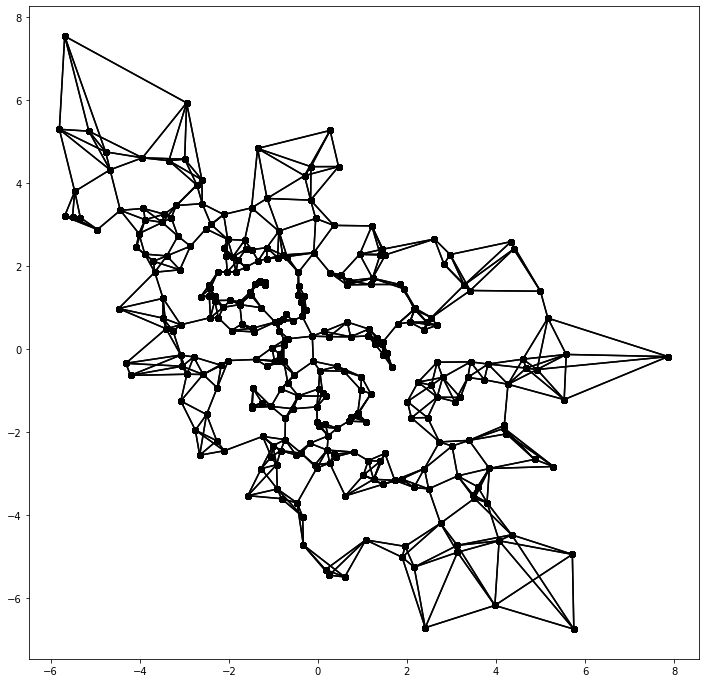

In [4]:
n = 300
mean = [0, 0]
cov = get_cov(princ_comp=[-1, 1], eigvals=[10, 3])
k = 4

Xs = get_gaussian(n_samples=n, mean=mean, cov=cov)
A = kneighbors_graph(Xs, k, mode='connectivity').toarray()
A = np.clip(A + A.T, a_min=None, a_max=1)
A = sp.csr_matrix(A)

plot_graph(Xs=Xs, A=A)

In [5]:
train_graph, sampled_graph, statistics_logger = main(A=A, 
                                                     H=4,
                                                     steps=400,
                                                     optimizer_args={'lr': 0.01})

relevant_keys = ['d_max', 'wedge_count', 'claw_count', 'triangle_count', 'square_count',
                 'power_law_exp', 'gini', 'spectral_gap', 'assortativity', 'clustering_coefficient',
                 'cpl', 'overlap']

statistics_logger.print_statistics(keys=relevant_keys, EO_criterion=0.52, max_patience_for_VAL=3)

Step: 49, Loss: 4.95383, Edge-Overlap: 0.030
Step: 99, Loss: 3.81738, Edge-Overlap: 0.127
Step: 149, Loss: 3.21974, Edge-Overlap: 0.217
Step: 199, Loss: 2.82269, Edge-Overlap: 0.310
Step: 249, Loss: 2.53945, Edge-Overlap: 0.390
Step: 299, Loss: 2.34511, Edge-Overlap: 0.489
Step: 349, Loss: 2.22302, Edge-Overlap: 0.568
Step: 399, Loss: 2.13997, Edge-Overlap: 0.575


#### Plot kNN graph vs learned graph to highlight new/shared edges

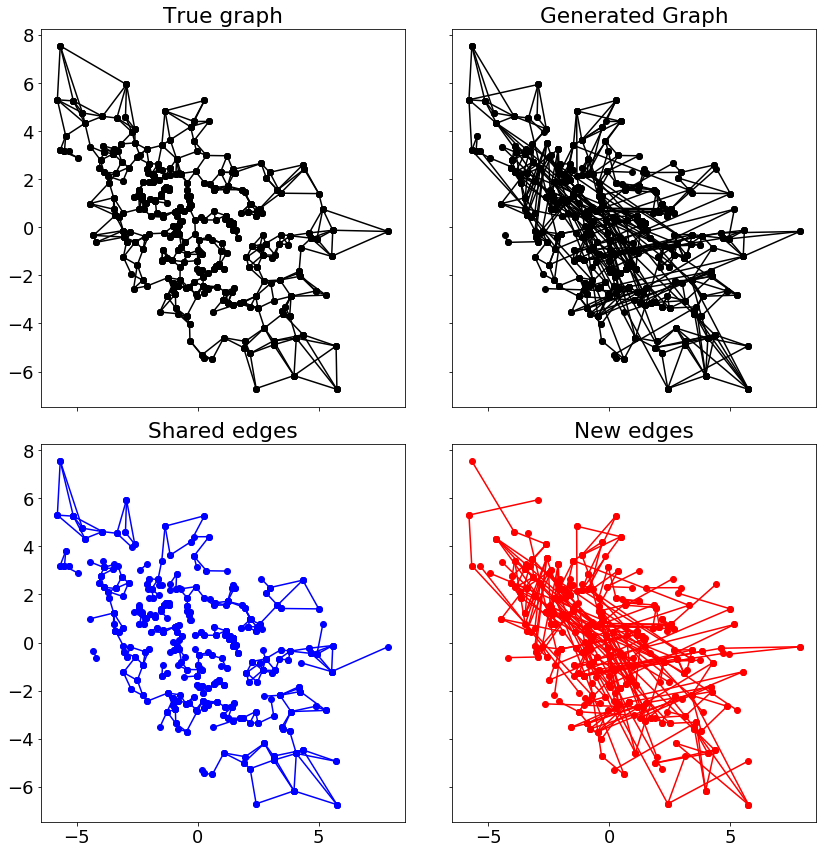

In [7]:
plot_compare(Xs=Xs, train_graph=train_graph.toarray(), sampled_graph=sampled_graph)

#### How long are the new generated edges compared to true edges?

In [10]:
true_average_edgelength = get_average_edgelength(Xs, train_graph.toarray())
generated_average_edgelength = get_average_edgelength(Xs, (1 - train_graph.toarray()) * sampled_graph)
dist_matrix = distance_matrix(Xs, Xs)
average_distance = dist_matrix.sum() /( len(Xs)*(len(Xs)-1))

In [11]:
print(f"Average edgelength in true kNN graph = {true_average_edgelength:.3f}")
print(f"Average edgelength for new edges = {generated_average_edgelength:.3f}")
print(f"Average edgelength between all points = {average_distance:.3f}")

Average edgelength in true kNN graph = 0.542
Average edgelength for new edges = 2.388
Average edgelength between all points = 4.181


**Interpretation:** Generative model doesn't respect local structure, because generated edges are not focusing on nearby points.

# 2) Stochastic Block Model

#### Generate SBM

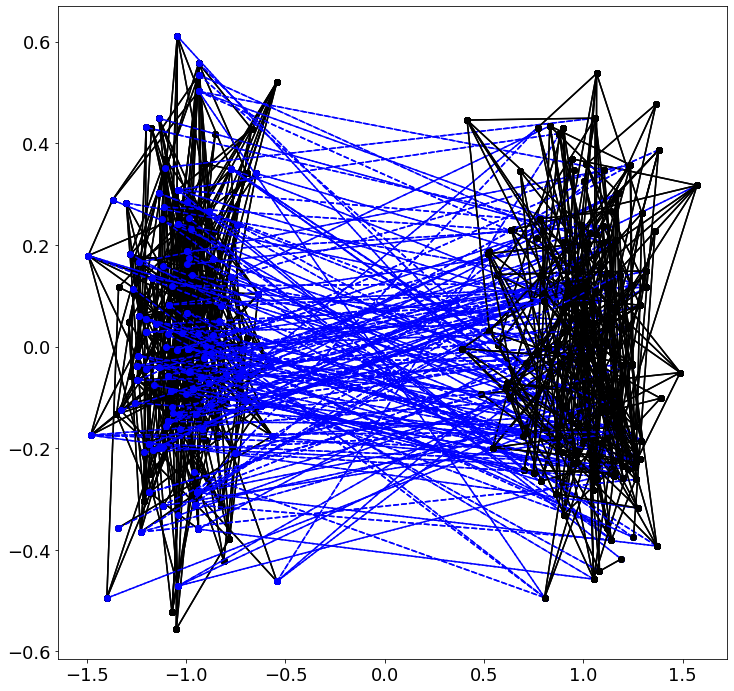

In [8]:
sizes = [150, 150]
p = 0.025
q = 0.008
probs = q * np.ones((len(sizes), len(sizes)))
np.fill_diagonal(probs, p)

Xs, Ys = classes_to_points(sizes)
G = nx.stochastic_block_model(sizes, probs)
A = nx.to_scipy_sparse_matrix(G)

plot_graph(Xs=Xs, A=A, classes=Ys)

Step: 49, Loss: 4.60995, Edge-Overlap: 0.057
Step: 99, Loss: 3.40793, Edge-Overlap: 0.238
Step: 149, Loss: 2.84302, Edge-Overlap: 0.337
Step: 199, Loss: 2.49506, Edge-Overlap: 0.480
Step: 249, Loss: 2.26050, Edge-Overlap: 0.538
Step: 299, Loss: 2.10450, Edge-Overlap: 0.609
Step: 349, Loss: 1.99521, Edge-Overlap: 0.640
Step: 399, Loss: 1.91413, Edge-Overlap: 0.722


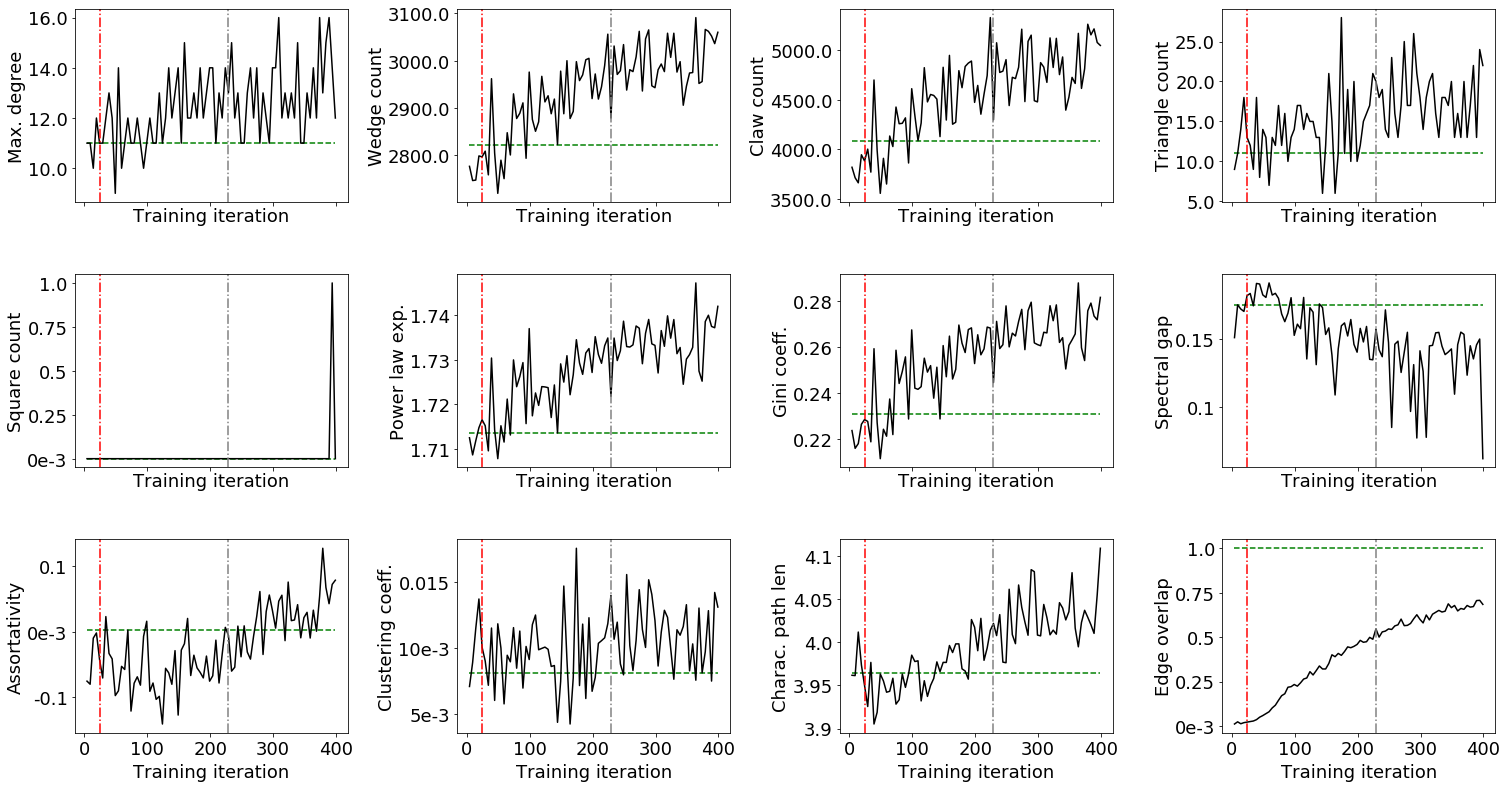

In [10]:
train_graph, sampled_graph, statistics_logger = main(A=A, 
                                                     H=8,
                                                     steps=400,
                                                     optimizer_args={'lr': 0.01})

relevant_keys = ['d_max', 'wedge_count', 'claw_count', 'triangle_count', 'square_count',
                 'power_law_exp', 'gini', 'spectral_gap', 'assortativity', 'clustering_coefficient',
                 'cpl', 'overlap']

statistics_logger.print_statistics(keys=relevant_keys, EO_criterion=0.52, max_patience_for_VAL=3)

#### Plot kNN graph vs learned graph to highlight new/shared edges

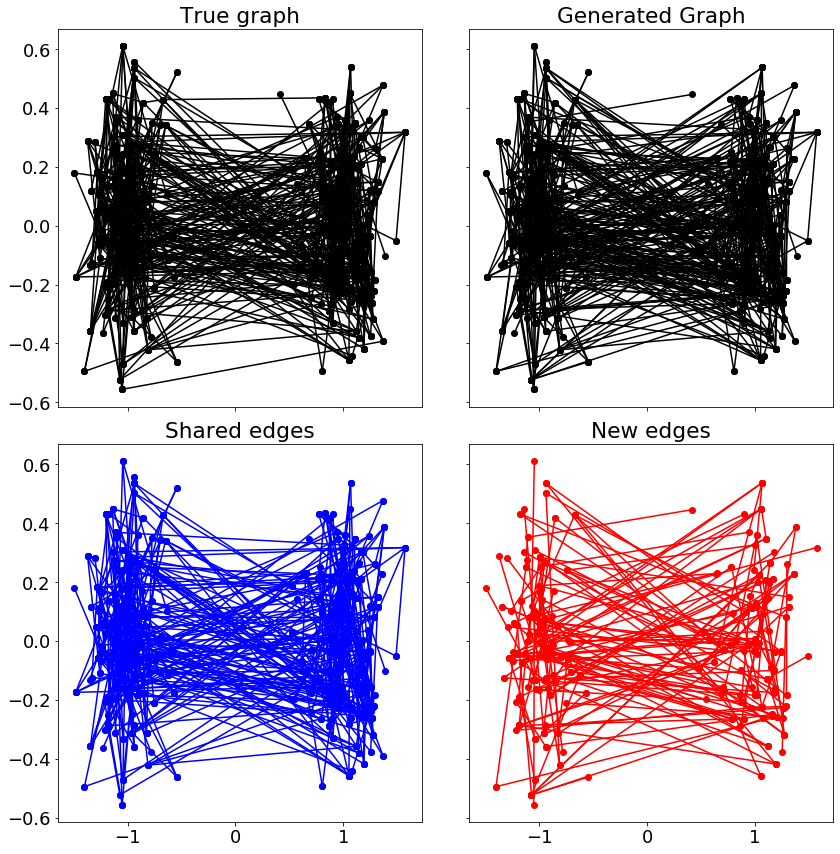

In [11]:
plot_compare(Xs=Xs, train_graph=train_graph.toarray(), sampled_graph=sampled_graph)

#### Ratio of edges within a class / between classes?


In [12]:
print(f"Theoretical ratio: {p/q:.3f}")
print(f"True graph: {get_ratio(A=train_graph.toarray(), Ys=Ys):.3f}")
print(f"Generated graph: {get_ratio(A=sampled_graph, Ys=Ys):.3f}")

Theoretical ratio: 3.125
True graph: 2.858
Generated graph: 2.019


**Interpretation:** Generative model doesn't respect classes, as ratio gets closer to 1

## 2.1) Bipartite graphs

#### Generate bipartite SBM

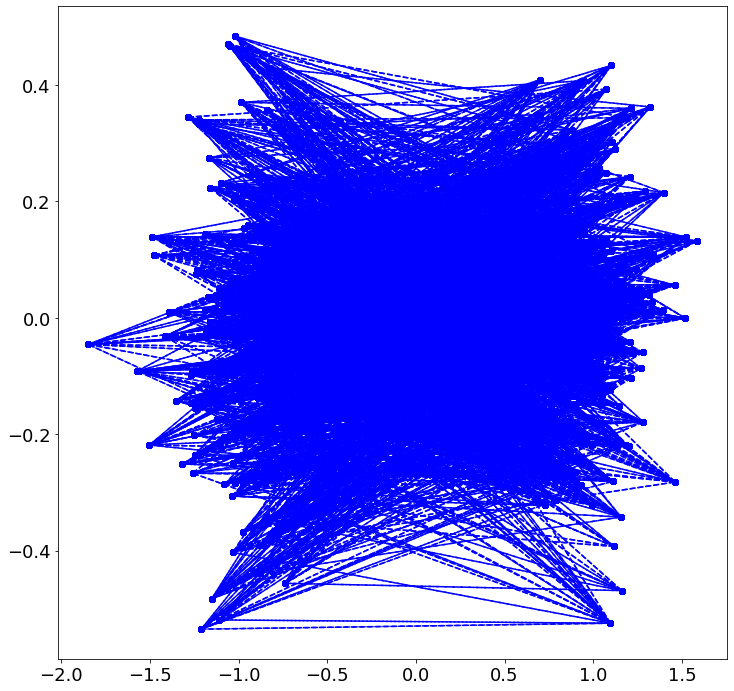

In [17]:
sizes = [150, 150]
p = 0
q = 0.1
probs = q * np.ones((len(sizes), len(sizes)))
np.fill_diagonal(probs, p)

Xs, Ys = classes_to_points(sizes)
G = nx.stochastic_block_model(sizes, probs)
A = nx.to_scipy_sparse_matrix(G)

plot_graph(Xs=Xs, A=A, classes=Ys)

Step: 49, Loss: 4.59822, Edge-Overlap: 0.169
Step: 99, Loss: 3.94870, Edge-Overlap: 0.333
Step: 149, Loss: 3.65032, Edge-Overlap: 0.413
Step: 199, Loss: 3.47968, Edge-Overlap: 0.474
Step: 249, Loss: 3.37079, Edge-Overlap: 0.518
Step: 299, Loss: 3.29192, Edge-Overlap: 0.551
Step: 349, Loss: 3.23043, Edge-Overlap: 0.564
Step: 399, Loss: 3.18095, Edge-Overlap: 0.578


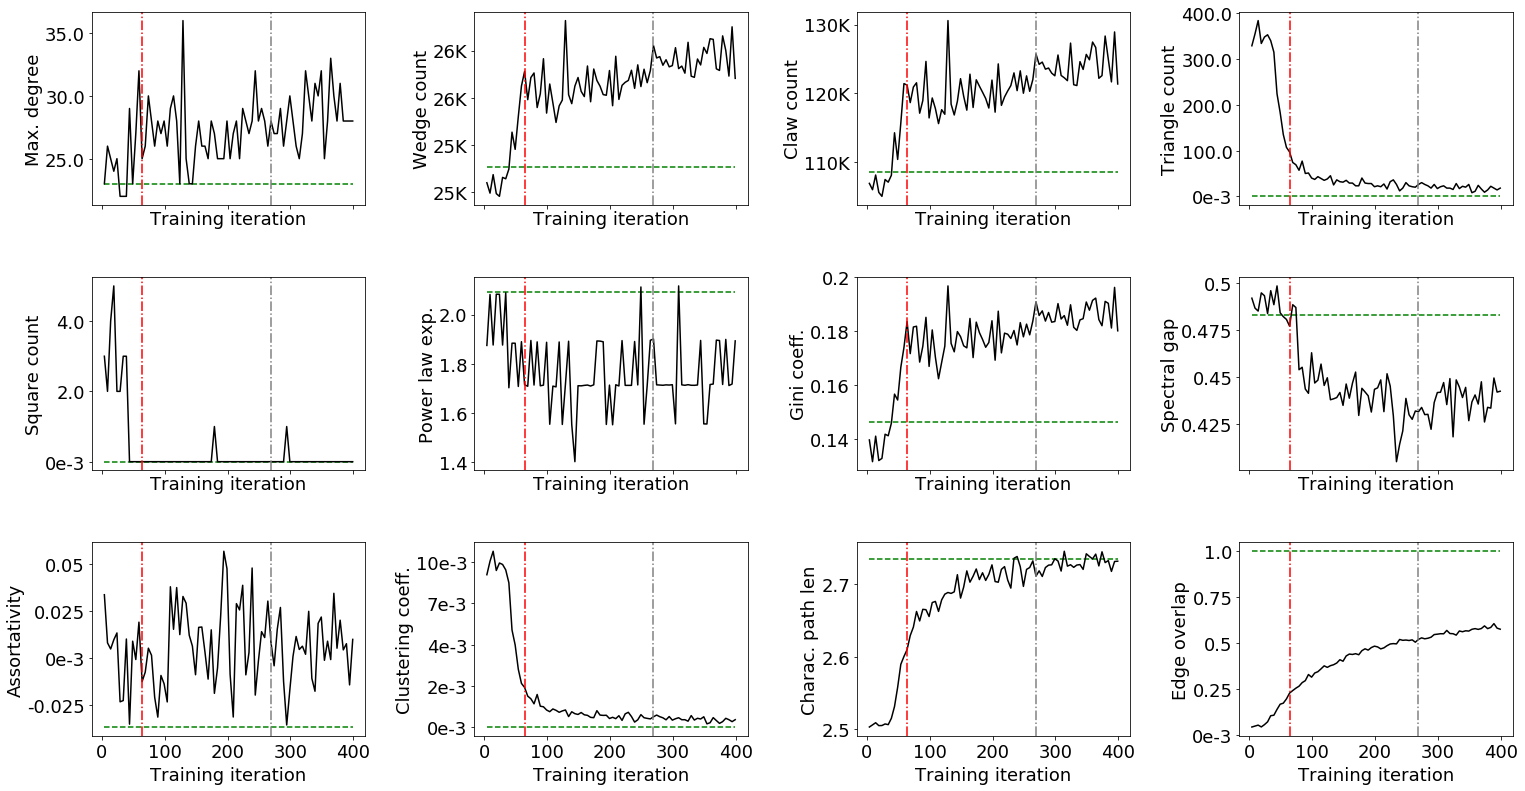

In [18]:
train_graph, sampled_graph, statistics_logger = main(A=A, 
                                                     H=13,
                                                     steps=400,
                                                     optimizer_args={'lr': 0.01})

relevant_keys = ['d_max', 'wedge_count', 'claw_count', 'triangle_count', 'square_count',
                 'power_law_exp', 'gini', 'spectral_gap', 'assortativity', 'clustering_coefficient',
                 'cpl', 'overlap']

statistics_logger.print_statistics(keys=relevant_keys, EO_criterion=0.52, max_patience_for_VAL=3)

#### Plot kNN graph vs learned graph to highlight new/shared edges

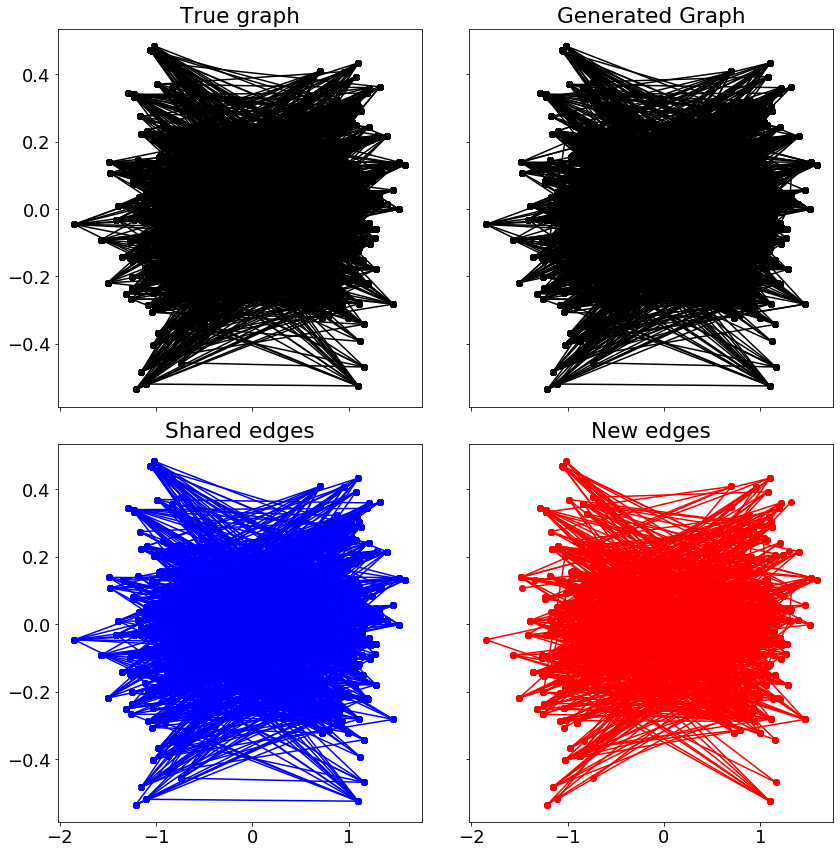

In [19]:
plot_compare(Xs=Xs, train_graph=train_graph.toarray(), sampled_graph=sampled_graph)

#### Ratio of edges within a class / between classes?


In [20]:
print(f"True graph: {get_ratio(A=train_graph.toarray(), Ys=Ys):.3f}")
print(f"Generated graph: {get_ratio(A=sampled_graph, Ys=Ys):.3f}")

True graph: 0.000
Generated graph: 0.008


**Interpretation:** Generative model respects bipartite structure?

## 2.2) Multiple classes

#### Generate bipartite SBM

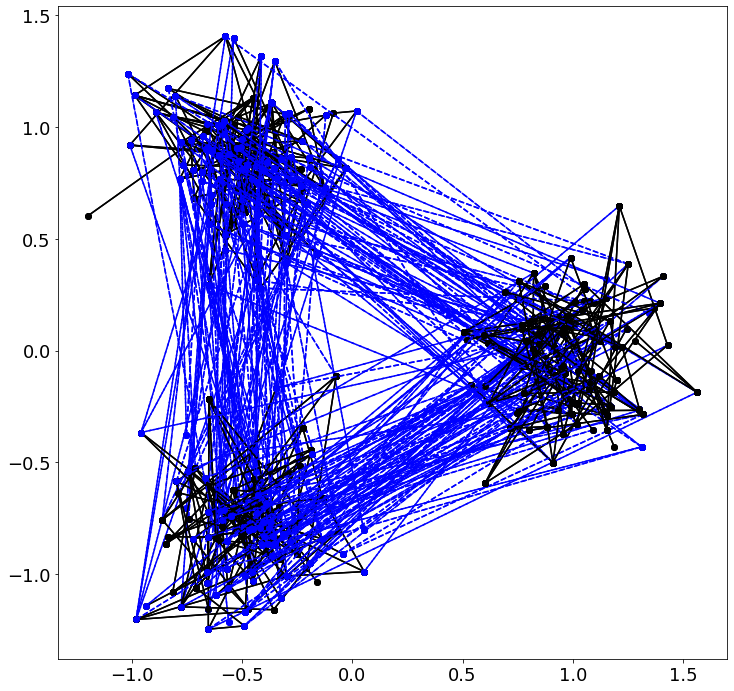

In [23]:
sizes = [100, 100, 100]
p = 0.025
q = 0.008
probs = q * np.ones((len(sizes), len(sizes)))
np.fill_diagonal(probs, p)

Xs, Ys = classes_to_points(sizes)
G = nx.stochastic_block_model(sizes, probs)
A = nx.to_scipy_sparse_matrix(G)

plot_graph(Xs=Xs, A=A, classes=Ys)

Step: 49, Loss: 5.00199, Edge-Overlap: 0.028
Step: 99, Loss: 4.23849, Edge-Overlap: 0.066
Step: 149, Loss: 3.85857, Edge-Overlap: 0.137
Step: 199, Loss: 3.61085, Edge-Overlap: 0.137
Step: 249, Loss: 3.44255, Edge-Overlap: 0.189
Step: 299, Loss: 3.32107, Edge-Overlap: 0.217
Step: 349, Loss: 3.22704, Edge-Overlap: 0.251
Step: 399, Loss: 3.14967, Edge-Overlap: 0.269


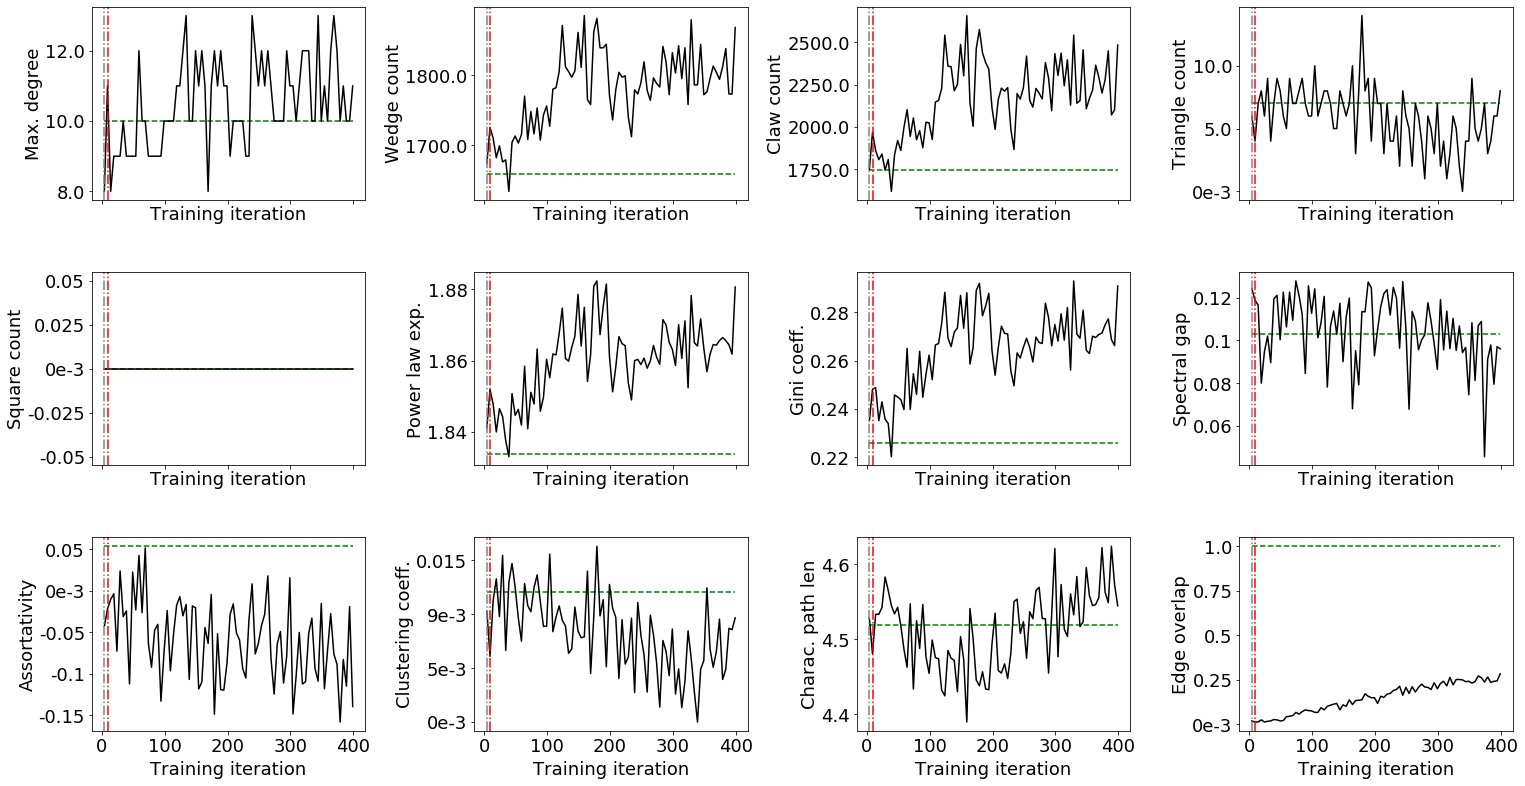

In [24]:
train_graph, sampled_graph, statistics_logger = main(A=A, 
                                                     H=4,
                                                     steps=400,
                                                     optimizer_args={'lr': 0.01})

relevant_keys = ['d_max', 'wedge_count', 'claw_count', 'triangle_count', 'square_count',
                 'power_law_exp', 'gini', 'spectral_gap', 'assortativity', 'clustering_coefficient',
                 'cpl', 'overlap']

statistics_logger.print_statistics(keys=relevant_keys, EO_criterion=0.52, max_patience_for_VAL=3)

#### Plot kNN graph vs learned graph to highlight new/shared edges

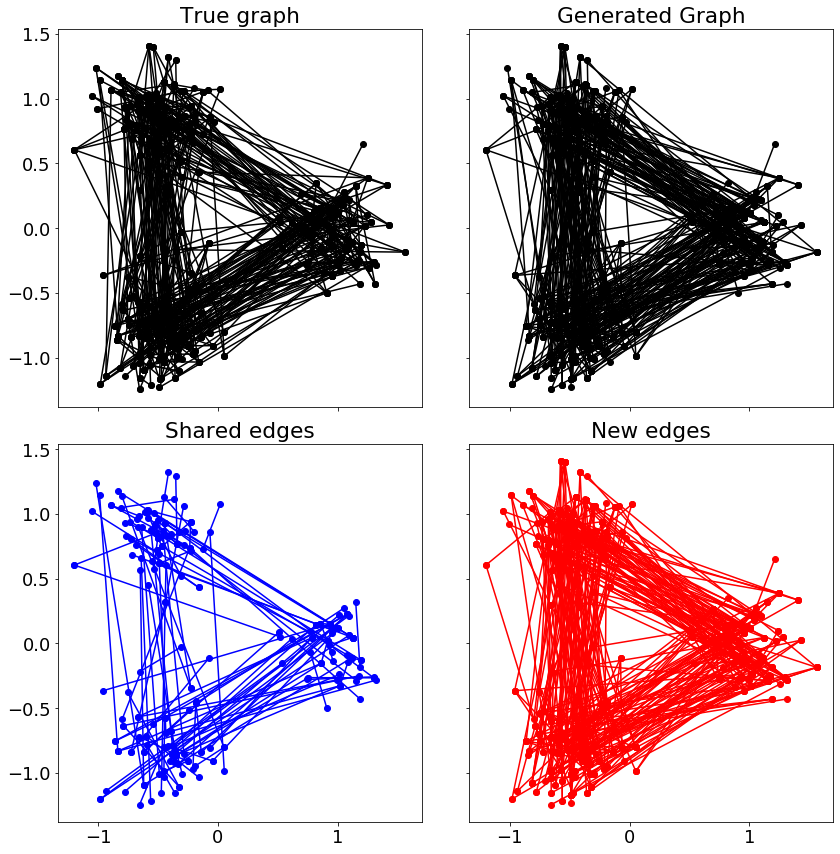

In [25]:
plot_compare(Xs=Xs, train_graph=train_graph.toarray(), sampled_graph=sampled_graph)

#### Ratio of edges within a class / between classes?


In [26]:
print(f"True graph: {get_ratio(A=train_graph.toarray(), Ys=Ys):.3f}")
print(f"Generated graph: {get_ratio(A=sampled_graph, Ys=Ys):.3f}")

True graph: 1.175
Generated graph: 0.660


**Interpretation:** Generative model respects bipartite structure?